1950 positive samples
1005 negative samples


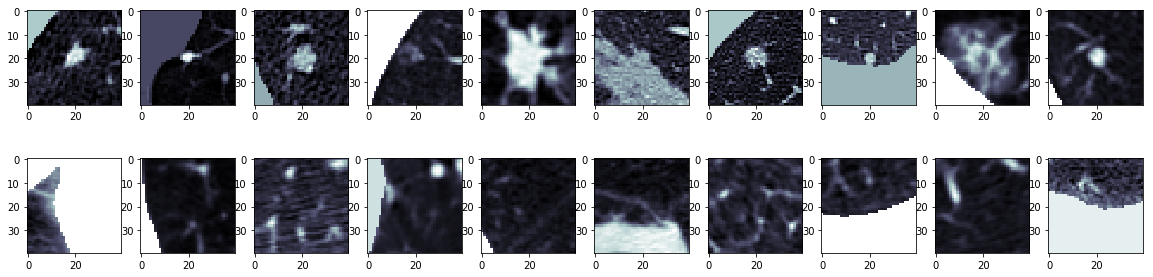

In [1]:
# Skinny 
import os
posiRepo='/data/tianchi_lung/posi_result'
negaRepo='/data/tianchi_lung/nega_result'
posiPkls = [os.path.join(posiRepo, x) for x in os.listdir(posiRepo)]
negaPkls = [os.path.join(negaRepo, x) for x in os.listdir(negaRepo)]
posiCnt=len(posiPkls)
negaCnt=len(negaPkls)
print("%d positive samples"%posiCnt)
print("%d negative samples"%negaCnt)

import pickle
posiPixels = []
negaPixels = []
for posiPklNames in posiPkls:
    mat=pickle.load(open(posiPklNames,'rb'))
    posiPixels.append(mat)
for negaPklNames in negaPkls:
    mat=pickle.load(open(negaPklNames,'rb'))
    negaPixels.append(mat)

# Randomly choose a collection of posi/nega samples, visualize them.    
import random
random.seed(42)
posiGallery=random.sample(posiPixels, 10)
negaGallery=random.sample(negaPixels, 10)

import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(posiGallery[i], cmap=plt.cm.bone)
    plt.subplot(2,10,i+11)
    plt.imshow(negaGallery[i], cmap=plt.cm.bone)
plt.show()

## Divide Posi/Nega Train/Test samples

In [2]:
import numpy as np
import random
trainFrac=0.9

# 随机取出正样本训练集、测试集
posiTrainCnt= int(posiCnt * trainFrac)
negaTrainCnt= int(negaCnt * trainFrac)
posiTrain = posiPixels[:posiTrainCnt ]
posiTest  = posiPixels[ posiTrainCnt:]

# 随机取出负样本训练集、测试集
posiTrainCnt = len(posiTrain)
posiTestCnt  = len(posiTest)
negaTrain = negaPixels[:negaTrainCnt ]
negaTest  = negaPixels[ negaTrainCnt:]
negaTrainCnt = len(negaTrain)
negaTestCnt  = len(negaTest)

# 合并正负样本，生成训练集测试集
trainX = posiTrain+negaTrain
testX = posiTest+negaTest

# 标出给正负样本贴上标签
trainY = [1]*posiTrainCnt + [0]*negaTrainCnt
testY = [1]*posiTestCnt + [0]*negaTestCnt

# 打乱训练集\测试集顺序
binded= list(zip(trainX,trainY))
random.shuffle(binded)
trainX,trainY = zip(*binded)

binded= list(zip(testX,testY))
random.shuffle(binded)
testX,testY = zip(*binded)

print("train#=%d v.s. test#=%d"%(posiTrainCnt+negaTrainCnt, posiTestCnt+negaTestCnt))
print("Within TrainSet, Posi/Nega=%d/%d"%(posiTrainCnt, negaTrainCnt))


train#=2659 v.s. test#=296
Within TrainSet, Posi/Nega=1755/904


## 画出训练集前20个，看一看

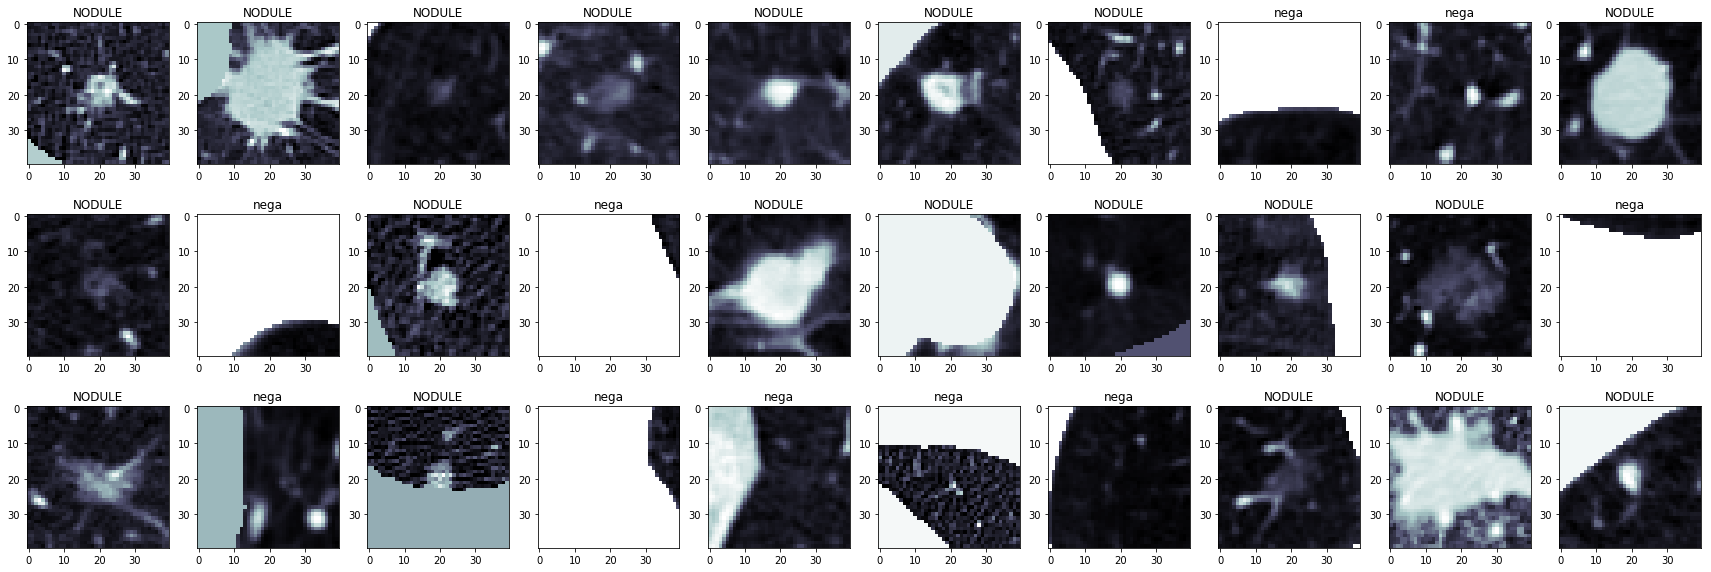

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
for i in range(30):
    #plt.subplot(2,10,i+1)
    plt.subplot(3,10,i+1).set_title("NODULE" if trainY[i]==1  else "nega")
    plt.imshow(trainX[i], cmap=plt.cm.bone)
plt.show()


## 画出测试集前20个，看一看

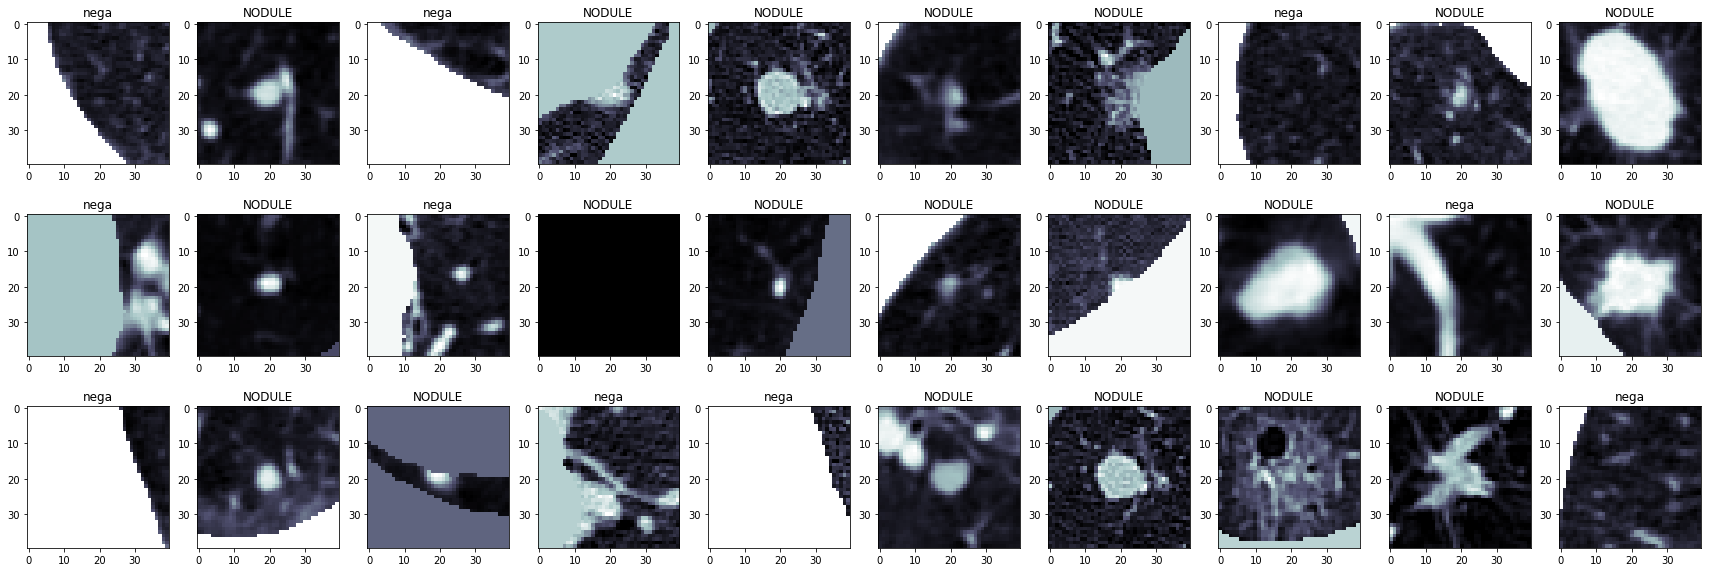

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
for i in range(30):
    #plt.subplot(2,10,i+1)
    plt.subplot(3,10,i+1).set_title("NODULE" if testY[i]==1  else "nega")
    plt.imshow(testX[i], cmap=plt.cm.bone)
plt.show()

## MLP 基准方法

In [67]:
import numpy as np
import copy

trainX_MLP = copy.deepcopy(trainX)
trainY_MLP = copy.deepcopy(trainY)
trainX_MLP = np.asarray(trainX_MLP)
trainY_MLP = np.asarray(trainY_MLP)
trainX_MLP.shape

testX_MLP = copy.deepcopy(testX)
testY_MLP = copy.deepcopy(testY)
testX_MLP = np.asarray(trainX_MLP)
testY_MLP = np.asarray(trainY_MLP)

#-----------------------------

import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

#     trainX_MLP,trainY_MLP,
#     testX_MLP,testY_MLP
# 把图像二维矩阵拍平成一维向量
# flatten 40*40 images to a 1600 vector for each image
num_pixels = trainX_MLP.shape[1] * trainX_MLP.shape[2]
trainX_MLP = trainX_MLP.reshape(trainX_MLP.shape[0], num_pixels).astype('float32')
testX_MLP  = testX_MLP.reshape (testX_MLP.shape[0],  num_pixels).astype('float32')

# 图像CT值归一化
# normalize inputs from 0-255 to 0-1
trainX_MLP = (trainX_MLP-(-2048)) /3000
testX_MLP  = (testX_MLP -(-2048)) /3000

# One-hot 类别编码
trainY_MLP = np_utils.to_categorical(trainY_MLP)
testY_MLP = np_utils.to_categorical(testY_MLP)
num_classes = testY_MLP.shape[1]
print("Data Preparation Finished")

Data Preparation Finished


In [68]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(60, input_dim=num_pixels, 
                    kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.23))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, 
                    kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])
    return model

# build the model
model = baseline_model()
# Fit the model
model.fit(trainX_MLP, trainY_MLP, 
          #validation_data=(testX_MLP, testY_MLP), 
          epochs=100, batch_size=900, verbose=2)
# Final evaluation of the model
scores = model.evaluate(testX_MLP, testY_MLP, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))


Epoch 1/100
0s - loss: 0.6834 - acc: 0.5671
Epoch 2/100
0s - loss: 0.6663 - acc: 0.6465
Epoch 3/100
0s - loss: 0.6463 - acc: 0.6563
Epoch 4/100
0s - loss: 0.6457 - acc: 0.6593
Epoch 5/100
0s - loss: 0.6281 - acc: 0.6687
Epoch 6/100
0s - loss: 0.6194 - acc: 0.6634
Epoch 7/100
0s - loss: 0.6142 - acc: 0.6713
Epoch 8/100
0s - loss: 0.5980 - acc: 0.6822
Epoch 9/100
0s - loss: 0.5932 - acc: 0.6781
Epoch 10/100
0s - loss: 0.5707 - acc: 0.6988
Epoch 11/100
0s - loss: 0.5612 - acc: 0.6927
Epoch 12/100
0s - loss: 0.5463 - acc: 0.7112
Epoch 13/100
0s - loss: 0.5442 - acc: 0.7089
Epoch 14/100
0s - loss: 0.5239 - acc: 0.7240
Epoch 15/100
0s - loss: 0.5190 - acc: 0.7194
Epoch 16/100
0s - loss: 0.5132 - acc: 0.7420
Epoch 17/100
0s - loss: 0.4917 - acc: 0.7484
Epoch 18/100
0s - loss: 0.4795 - acc: 0.7522
Epoch 19/100
0s - loss: 0.4757 - acc: 0.7619
Epoch 20/100
0s - loss: 0.4672 - acc: 0.7522
Epoch 21/100
0s - loss: 0.4489 - acc: 0.7894
Epoch 22/100
0s - loss: 0.4423 - acc: 0.7875
Epoch 23/100
0s - l

In [51]:
prob=model.predict(testX_MLP)
len(prob)

2659

## CNN 改进方法

In [65]:
import numpy as np
import copy

trainX_CNN = copy.deepcopy(trainX)
trainY_CNN = copy.deepcopy(trainY)
trainX_CNN = np.asarray(trainX_CNN)
trainY_CNN = np.asarray(trainY_CNN)
trainX_CNN.shape

testX_CNN = copy.deepcopy(testX)
testY_CNN = copy.deepcopy(testY)
testX_CNN = np.asarray(trainX_CNN)
testY_CNN = np.asarray(trainY_CNN)

# 图像CT值归一化
# normalize inputs from 0-255 to 0-1
trainX_CNN = (trainX_CNN-(-2048)) /3000
testX_CNN  = (testX_CNN -(-2048)) /3000


# Larger CNN for the MNIST Dataset
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

K.set_image_dim_ordering('th')
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# reshape to be [samples][pixels][width][height]
trainX_CNN = trainX_CNN.reshape(trainX_CNN.shape[0], 1, 40, 40).astype('float32')
testX_CNN  = testX_CNN.reshape(testX_CNN.shape[0], 1, 40, 40).astype('float32')


# One-hot 类别编码
trainY_CNN  = np_utils.to_categorical(trainY_CNN)
testY_CNN   = np_utils.to_categorical(testY_CNN)
num_classes = testY_CNN.shape[1]
print("Data Preparation Finished")

Data Preparation Finished


In [72]:
# define the larger model
def larger_model():
    # create model
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(1, 40, 40), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# build the model
model = larger_model()
# Fit the model
model.fit(trainX_CNN, trainY_CNN, 
          #validation_data=(X_test, y_test), 
          epochs=200, batch_size=100)
# Final evaluation of the model
scores = model.evaluate(testX_CNN, testY_CNN, verbose=0)
print("Large CNN Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/200
2659/2659 [==============================] - 1s - loss: 0.5984 - acc: 0.6800     
Epoch 2/200
2659/2659 [==============================] - 0s - loss: 0.5430 - acc: 0.7209     
Epoch 3/200
2659/2659 [==============================] - 0s - loss: 0.4640 - acc: 0.7616     
Epoch 4/200
2659/2659 [==============================] - 0s - loss: 0.3948 - acc: 0.8210     
Epoch 5/200
2659/2659 [==============================] - 0s - loss: 0.3668 - acc: 0.8372     
Epoch 6/200
2659/2659 [==============================] - 0s - loss: 0.3542 - acc: 0.8545     
Epoch 7/200
2659/2659 [==============================] - 0s - loss: 0.3264 - acc: 0.8718     
Epoch 8/200
2659/2659 [==============================] - 0s - loss: 0.3086 - acc: 0.8766     
Epoch 9/200
2659/2659 [==============================] - 0s - loss: 0.3051 - acc: 0.8725     
Epoch 10/200
2659/2659 [==============================] - ETA: 0s - loss: 0.2829 - acc: 0.887 - 0s - loss: 0.2842 - acc: 0.8868     
Epoch 11/200
2659/265

2659/2659 [==============================] - 0s - loss: 0.0206 - acc: 0.9876     
Epoch 87/200
2659/2659 [==============================] - 0s - loss: 0.0232 - acc: 0.9891     
Epoch 88/200
2659/2659 [==============================] - 0s - loss: 0.0178 - acc: 0.9906     
Epoch 89/200
2659/2659 [==============================] - 0s - loss: 0.0229 - acc: 0.9883     
Epoch 90/200
2659/2659 [==============================] - 0s - loss: 0.0223 - acc: 0.9887     
Epoch 91/200
2659/2659 [==============================] - 0s - loss: 0.0249 - acc: 0.9868     
Epoch 92/200
2659/2659 [==============================] - 0s - loss: 0.0220 - acc: 0.9865     
Epoch 93/200
2659/2659 [==============================] - 0s - loss: 0.0216 - acc: 0.9861     
Epoch 94/200
2659/2659 [==============================] - 0s - loss: 0.0191 - acc: 0.9883     
Epoch 95/200
2659/2659 [==============================] - 0s - loss: 0.0235 - acc: 0.9898     
Epoch 96/200
2659/2659 [==============================] - 0s - 

2659/2659 [==============================] - 0s - loss: 0.0114 - acc: 0.9962     
Epoch 172/200
2659/2659 [==============================] - 0s - loss: 0.0067 - acc: 0.9977     
Epoch 173/200
2659/2659 [==============================] - 0s - loss: 0.0074 - acc: 0.9985     
Epoch 174/200
2659/2659 [==============================] - 0s - loss: 0.0074 - acc: 0.9977     
Epoch 175/200
2659/2659 [==============================] - 0s - loss: 0.0050 - acc: 0.9989     
Epoch 176/200
2659/2659 [==============================] - 0s - loss: 0.0141 - acc: 0.9974     
Epoch 177/200
2659/2659 [==============================] - 0s - loss: 0.0191 - acc: 0.9944     
Epoch 178/200
2659/2659 [==============================] - 0s - loss: 0.0107 - acc: 0.9974     
Epoch 179/200
2659/2659 [==============================] - 0s - loss: 0.0114 - acc: 0.9966     
Epoch 180/200
2659/2659 [==============================] - 0s - loss: 0.0090 - acc: 0.9966     
Epoch 181/200
2659/2659 [=============================